In [131]:
import glob, os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import smart_resize
import pandas as pd
import matplotlib.pyplot as plt
import itertools


In [132]:
tf.config.experimental.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Preprocessing

In [133]:
img_meta_df = pd.read_csv("data/crop_metadata.csv")

In [188]:
CLASS = 'family'

In [189]:
dirname = "./data/processed_crops"
(img_height, img_width) = (100, 100)
img_meta_df = img_meta_df.dropna(subset=[CLASS])
data_df = pd.DataFrame(columns=img_meta_df.columns)

n = 10000
img_arrays = np.ones((min(len(img_meta_df), n), img_height, img_width, 1), np.uint8)
i = 0
for index, row in img_meta_df.iterrows():
    if (i!=0 and i%n==0):
        print("{} samples loaded\r".format(i), end="", flush=True)
        break
    path_name = os.path.join(dirname, row['file_name'])
   
    if os.path.exists(path_name):
        loaded_img = load_img(path_name, color_mode="grayscale",)
        img_array = img_to_array(loaded_img)
        img_arrays[i] = img_array
        data_df = data_df.append(row)
        i+=1
        
    
        

{'Lethrinidae': 13205, 'Labridae': 13064, 'Pomacentridae': 6272, 'Lutjanidae': 6041, 'Carangidae': 5632, 'Acanthuridae': 5548, 'Caesionidae': 4636, 'Serranidae': 3952, 'Scaridae': 3509, 'Balistidae': 3349, 'Nemipteridae': 2957, 'Mullidae': 2530, 'Chaetodontidae': 2264, 'Siganidae': 2018, 'Carcharhinidae': 1015, 'Pomacanthidae': 679, 'Scombridae': 436, 'Tetraodontidae': 402, 'Sphyraenidae': 356, 'Pinguipedidae': 332, 'Synodontidae': 274, 'Echeneidae': 252, 'Haemulidae': 222, 'Monacanthidae': 198, 'Kyphosidae': 176, 'Cirrhitidae': 167, 'Zanclidae': 128, 'Fistulariidae': 104, 'Microdesmidae': 90, 'Apogonidae': 81, 'Atherinidae': 78, 'Malacanthidae': 72, 'Chanidae': 70, 'Pseudochromidae': 66, 'Blenniidae': 62, 'Sparidae': 62, 'Gobiidae': 54, 'Dasyatidae': 40, 'Mugilidae': 36, 'Ostraciidae': 32, 'Aulostomidae': 28, 'Rachycentridae': 24, 'Ephippidae': 24, 'Plotosidae': 24, 'Belonidae': 24, 'Priacanthidae': 22, 'Holocentridae': 20, 'Pempherididae': 20, 'Rhynchobatidae': 20, 'Gerreidae': 14, '

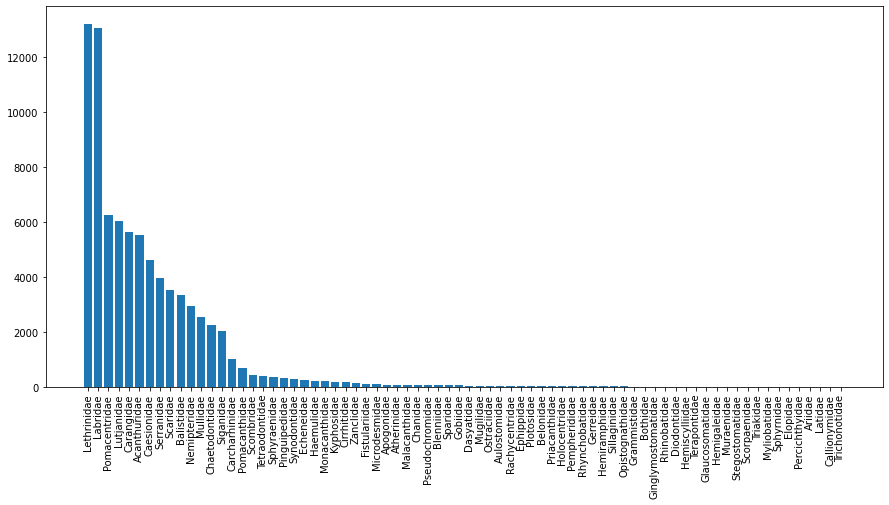

In [190]:
y = data_df[CLASS].to_numpy()
data = np.array([img_arrays[i] for i in range(n)])

counts = img_meta_df[CLASS].value_counts()
x = range(len(counts))
print(counts.to_dict())

plt.figure(figsize=(15,7))
plt.bar(x, counts)
plt.xticks(x, counts.index, rotation=90)
plt.show()

In [191]:
data.shape

(10000, 100, 100, 1)

In [192]:
def show_images_sample(generator, root_sample_size):
    fig, axs = plt.subplots(root_sample_size, root_sample_size, figsize=(15,15))
    img_arrays = list(itertools.islice(generator, root_sample_size**2))

    i=0
    for row in axs:
        for ax in row:
            if i < len(img_arrays):
                ax.imshow(img_arrays[i])
            else:
                break
            i+=1

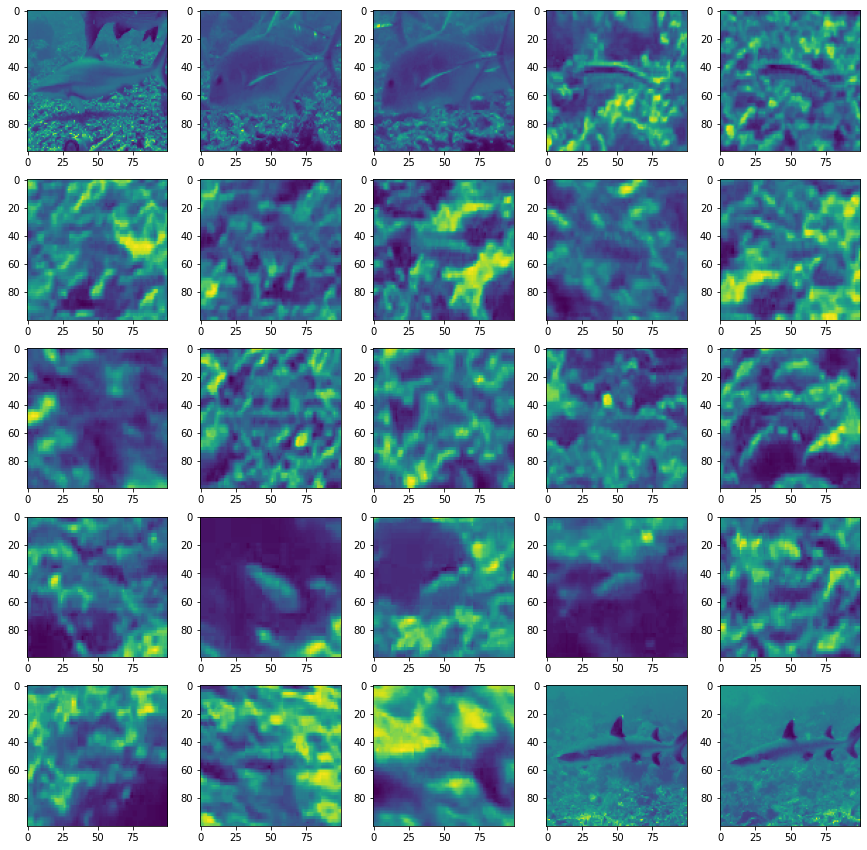

In [193]:
show_images_sample(data, 5)

## Data Setup

In [194]:
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size = 0.8)

In [195]:
oh_enc = OneHotEncoder(handle_unknown='ignore').fit(y.reshape(-1,1))
y_train_ohe = oh_enc.transform(y_train.reshape(-1,1))
y_test_ohe = oh_enc.transform(y_test.reshape(-1,1))

In [196]:
or_enc = OrdinalEncoder().fit(y.reshape(-1,1))
y_train_ore = or_enc.transform(y_train.reshape(-1,1))
y_test_ore = or_enc.transform(y_test.reshape(-1,1))

In [197]:
X_train.shape

(8000, 100, 100, 1)

In [198]:
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train_ohe.toarray())

X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test_ohe.toarray())

In [199]:
input_shape = X_train_tensor[0].shape
num_classes = y_train_ohe.toarray()[0].shape[0]
print("Input shape:", input_shape, "\nNumber of classes:", num_classes)

Input shape: (100, 100, 1) 
Number of classes: 38


In [200]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=0, 
    width_shift_range=0,
    height_shift_range=0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0,
    channel_shift_range=0.5, 
    fill_mode='nearest', 
    cval=0.0,
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=None,
    preprocessing_function=None, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None
)

datagen_data = X_train_tensor

datagen.fit(datagen_data)

train_iterator = datagen.flow(X_train_tensor, y_train_tensor, subset='training')
val_iterator = datagen.flow(X_train_tensor, y_train_tensor, subset='validation')
test_iterator = datagen.flow(X_test_tensor, y_test_tensor)

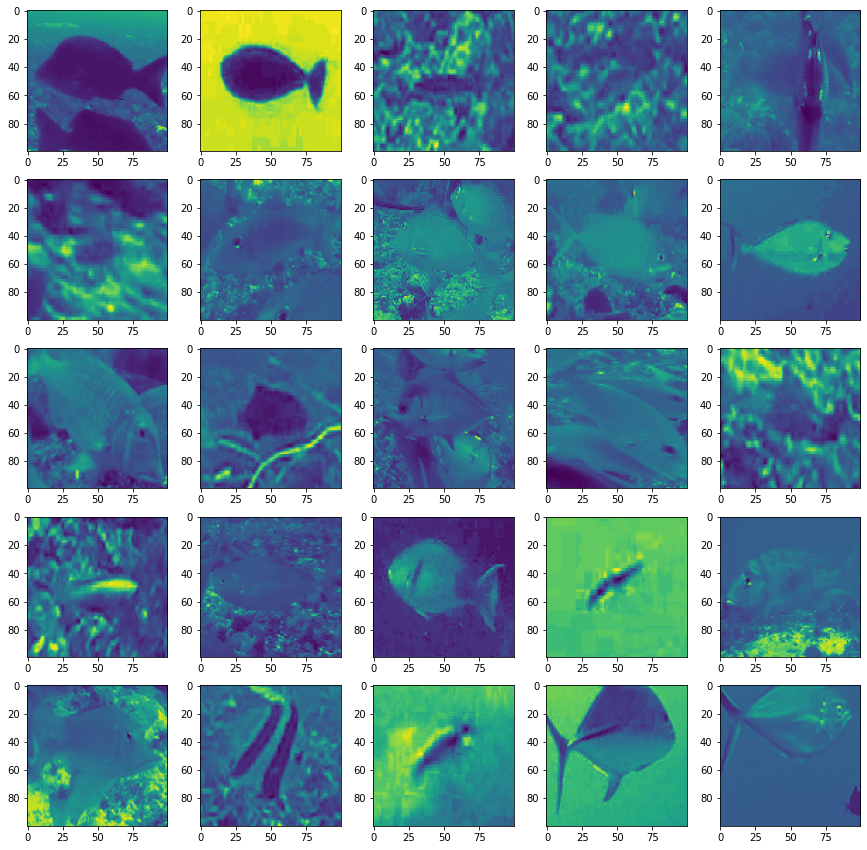

In [201]:
show_images_sample(next(train_iterator)[0], 5)

## Model Setup

In [202]:
drop_rate = .3

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1),activation='relu',input_shape=input_shape))
model.add(tf.keras.layers.SpatialDropout2D(drop_rate))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.SpatialDropout2D(drop_rate))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
             )


In [203]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 98, 16)        160       
_________________________________________________________________
spatial_dropout2d_16 (Spatia (None, 98, 98, 16)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 47, 47, 32)        4640      
_________________________________________________________________
spatial_dropout2d_17 (Spatia (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16928)            

In [204]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name) for l in model.layers]

(None, 100, 100, 1) <dtype: 'float32'>
(None, 38) <dtype: 'float32'>
conv2d_16
spatial_dropout2d_16
max_pooling2d_16
conv2d_17
spatial_dropout2d_17
max_pooling2d_17
flatten_8
dense_16
dense_17


[None, None, None, None, None, None, None, None, None]

In [211]:
MODEL_WEIGHTS_PATH = "model_weights.h5"

if(os.path.exists(MODEL_WEIGHTS_PATH)):
    model.load_weights("model_weights.h5")
else:
    model.fit(train_iterator, epochs=20, verbose=1, validation_data=val_iterator)

In [218]:
model.evaluate(test_iterator)

63/63 [==============================] - 2s 29ms/step - loss: 1.6829 - accuracy: 0.5555


[1.682895302772522, 0.5554999709129333]

In [208]:
model.save(MODEL_WEIGHTS_PATH)

In [209]:
next(test_iterator)[0][0].shape

(100, 100, 1)

In [207]:
sample = next(test_iterator)[0]

predictions = model.predict(sample)

for prediction in predictions:
    print(or_enc.inverse_transform(prediction.argmax().reshape(-1, 1))[0][0])

Carangidae
Scaridae
Lethrinidae
Pomacentridae
Carangidae
Lethrinidae
Carangidae
Acanthuridae
Zanclidae
Lethrinidae
Pomacentridae
Carangidae
Carangidae
Lethrinidae
Lethrinidae
Carangidae
Labridae
Chaetodontidae
Labridae
Labridae
Lethrinidae
Labridae
Pomacanthidae
Lethrinidae
Serranidae
Lethrinidae
Labridae
Acanthuridae
Labridae
Labridae
Labridae
Caesionidae
